In [1]:
import data_patterns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from visual import plot
import math
import os

ModuleNotFoundError: No module named 'visual'

In [ ]:
filepath = 'dataset_metadata.csv'

with open(filepath, 'r') as f:
    df = pd.read_csv(f)

## treat data in listed column(s) as numeric
numeric_columns = ['dateIdentified'] 
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.head()

,catalogNumber,sourceCategory,dateIdentified,database,language,observ,PDF,Corpus_PDF_references,References Endnote,associatedReferences,locationAccordingTo,Unnamed: 11
0,NS1517,Literature,1763.0,Psyl'list,English,freely available online,PDF,1763_Scopoli_1763_Chermes = Cacopsylla_pruni e...,Scopoli JA (1763),https://www.hemiptera-databases.org/psyllespdf...,Scopoli JA (1763) Entomologia Carniolica exhib...,NaN
1,NS0890,Literature,1805.0,BHL,German,freely available online,PDF,1805_Bechstein_extrait,Bechstein (1805),https://doi.org/10.5962/bhl.title.16563,Bechstein JM & Scharfenberg GL (1805) Vollstan...,NaN
2,NS1122,Literature,1837.0,BHL,English,freely available online,PDF,1837_Curtis_Cacopsylla_pruni_Britain_page_220,Curtis J (1837),https://doi.org/10.5962/bhl.title.46860,Curtis J (1837) A guide to an arrangement of B...,NaN
3,NS0891,Literature,1848.0,Psyl'list,German,freely available online,PDF,1848_Foerster_psyllids1,Foerster (1848),https://www.hemiptera-databases.org/psyllespdf...,Foerster A (1848) Uebersicht der gattungen und...,NaN
4,NS0892,Literature,1848.0,Psyl'list,German,freely available online,PDF,1848_Foerster_psyllids1,Foerster (1848),https://www.hemiptera-databases.org/psyllespdf...,Foerster A (1848) Uebersicht der gattungen und...,NaN


## Preprocess dataset

In [ ]:
# group attributes for members of the same group to be ignored during 
ordinal_attributes = ['dateIdentified'] 
categorical_attributes = ['sourceCategory','database','language','observ','PDF','interordinalDate']
interordinal_date = [np.nan if pd.isna(y) else int(str((y))[:-3]+'0') for y in df['dateIdentified']]
df['interordinalDate'] = interordinal_date
attributes = ordinal_attributes+categorical_attributes

print(attributes)

['dateIdentified', 'sourceCategory', 'database', 'language', 'observ', 'PDF', 'interordinalDate']


In [ ]:
df = df[attributes]
df.head()

,dateIdentified,sourceCategory,database,language,observ,PDF,interordinalDate
0,1763.0,Literature,Psyl'list,English,freely available online,PDF,1760.0
1,1805.0,Literature,BHL,German,freely available online,PDF,1800.0
2,1837.0,Literature,BHL,English,freely available online,PDF,1830.0
3,1848.0,Literature,Psyl'list,German,freely available online,PDF,1840.0
4,1848.0,Literature,Psyl'list,German,freely available online,PDF,1840.0


In [ ]:
ohe = OneHotEncoder()
df_e = pd.DataFrame(ohe.fit_transform(df[categorical_attributes].to_numpy()).toarray())
df_e.columns = ohe.get_feature_names_out(categorical_attributes)

In [ ]:
'''
for ord_att in ordinal_attributes:
    df_e[ord_att]=df[ord_att]
df_e.head()
'''

'\nfor ord_att in ordinal_attributes:\n    df_e[ord_att]=df[ord_att]\ndf_e.head()\n'

## Dataset visualisation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


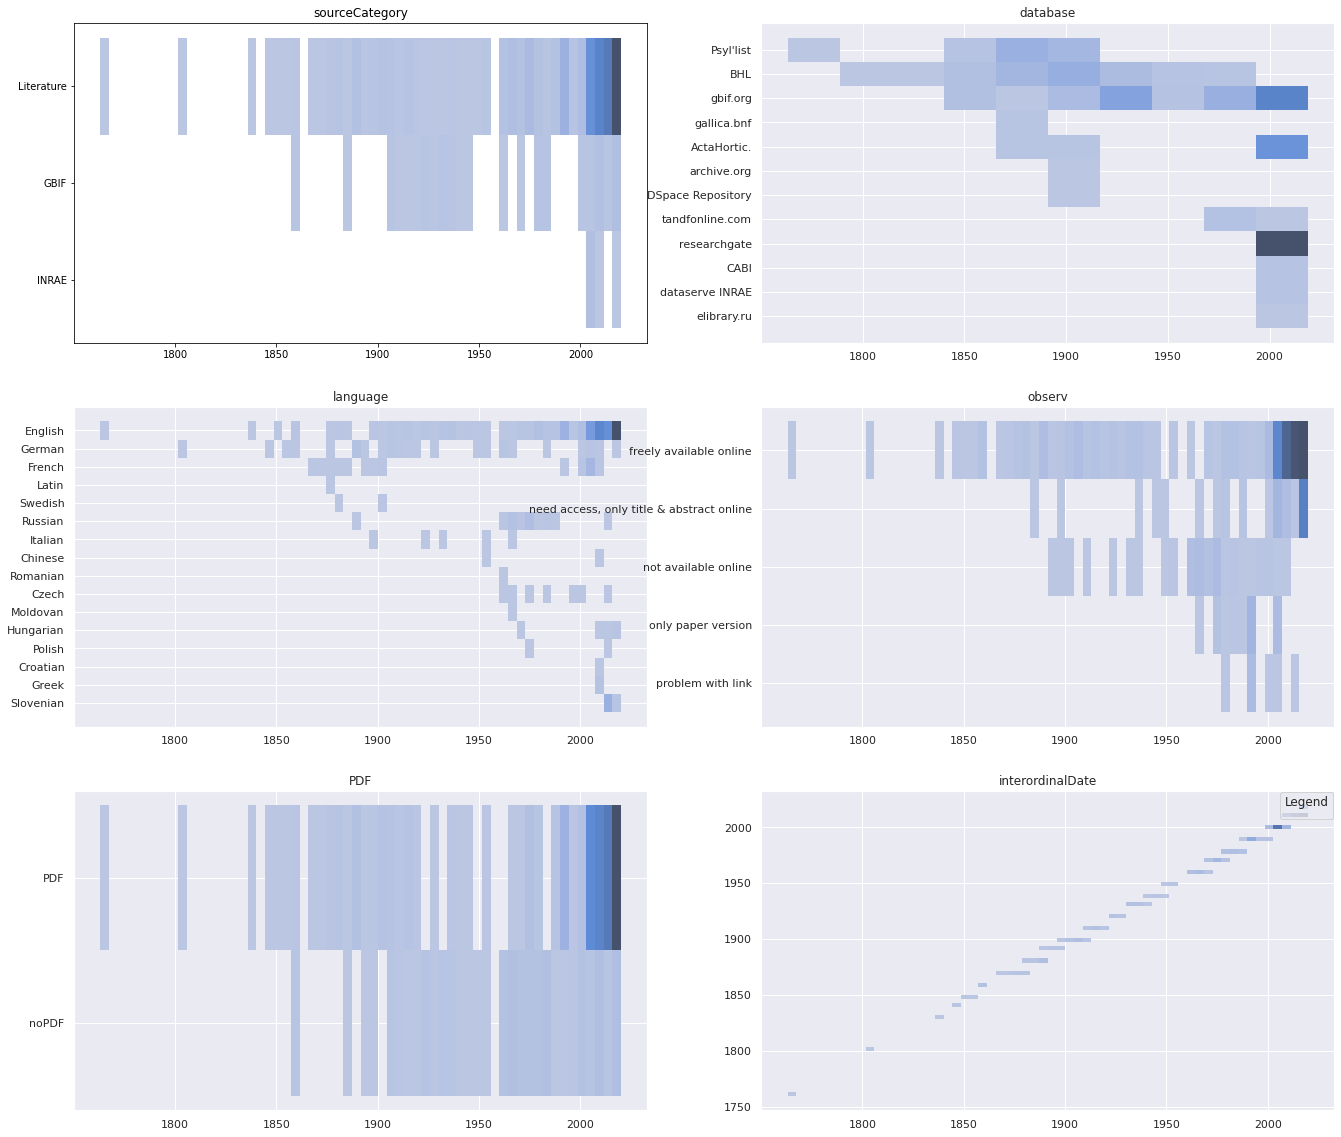

In [ ]:
fig = plt.figure(1, figsize=(20.0,20.0))
c = 0
for v in attributes:
    if v == ordinal_attributes[0]:
        continue
    c += 1
    chart = fig.add_subplot(3,2,c)
    chart.title.set_text(v)

    sns.set(font_scale=1)
    sns.histplot(df, x=ordinal_attributes[0], y=v, stat="probability", multiple="fill",
                            palette='Blues', legend=False)
    chart.set(xlabel=None)
    chart.set(ylabel=None)

chart.legend(loc="upper right",
            borderaxespad=0.1,
            title="Legend")

plt.subplots_adjust(right=1)
plt.show()

## Interestingness Measure

In [ ]:
import pysubgroup as ps

In [ ]:
attributes_grouped = {name:[name] for name in df_e.columns}

source_group_kws = [('sourceCategory','database'),('dateIdentified','interordinalDate')]
source_group_colnames = [] 

for group in source_group_kws:
    attributes_grouped['-'.join(group)] = list()

for group in source_group_kws:
    for kw in group:
        for k,v in attributes_grouped.items():
            if k.startswith(kw):
                attributes_grouped['-'.join(group)].append(k)

for group in source_group_kws:
    for k in list(attributes_grouped['-'.join(group)]):
        attributes_grouped.pop(k)

### define class

In [ ]:
class AssociationFinder():
    def find_ar_from_attribute(self,
                                df,
                                attribute,
                                value,
                                result_set_size=20, 
                                depth=50,
                                measure=ps.WRAccQF,
                                encoded=False):

        if encoded: # if df is encoded, attribute and value are both enclosed in column name
            attribute=str(attribute+'='+str(value))
            value=True
            
        target = ps.BinaryTarget (attribute, value)
        #print('target', target)
        searchspace = ps.create_selectors(df)
        task = ps.SubgroupDiscoveryTask (df, 
                                        target, 
                                        searchspace, 
                                        result_set_size=result_set_size, 
                                        depth=depth, 
                                        qf=measure())
        result = ps.BeamSearch().execute(task)
        return result

    def find_association_rules(self,
                            df,
                            attributes_grouped, 
                            result_set_size=20, 
                            depth=50,
                            measure=ps.WRAccQF,
                            encoded=False):
        ar_dict = dict()
        for a_group in attributes_grouped.values():
            for a in a_group:
                #print('a:',a)
                if encoded:
                    for av in [col for col in df.columns if col.split('=')[0] in a_group]:
                        #print('av:',av)
                        v=av.split('=')[-1]
                        #print('v',v)
                        association_rules = self.find_ar_from_attribute(
                                                                df=df,
                                                                attribute=a,
                                                                value=v,
                                                                result_set_size=result_set_size, 
                                                                depth=depth,
                                                                measure=measure,
                                                                encoded=encoded)
                        ar_dict[str(a+'='+str(v))]=association_rules
                        #print(association_rules.to_dataframe())
                else:
                    for v in df[a].unique():
                        #print('v:',v)
                        association_rules = self.find_ar_from_attribute(
                                                                df=df,
                                                                attribute=a,
                                                                value=v,
                                                                result_set_size=result_set_size, 
                                                                depth=depth,
                                                                measure=measure,
                                                                encoded=encoded)
                        ar_dict[str(a+'='+str(v))]=association_rules
                        #print(association_rules.to_dataframe())
            break # to only compute association rules related to the first group
                   
        ar_dfs = [v.to_dataframe().assign(attribute_value=k) for k,v in ar_dict.items()]
        ar_df = pd.concat(ar_dfs)

        # move attribute_value column to front
        val = ar_df['attribute_value']
        ar_df.drop(labels=['attribute_value'], axis=1,inplace = True)
        ar_df.insert(0, 'attribute_value', val)
        
        # reset indices
        ar_df.reset_index(inplace=True) 
        return ar_df


### Find associations

In [ ]:
AR=AssociationFinder()
ar_df= AR.find_association_rules(df=df_e,
                        attributes_grouped=attributes_grouped)

/home/elubrini/GitHub/psylve/venv/lib/python3.10/site-packages/pysubgroup/utils.py:234: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  df = pd.DataFrame(res, columns=headers, dtype=np.float64)
/home/elubrini/GitHub/psylve/venv/lib/python3.10/site-packages/pysubgroup/utils.py:234: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  df = pd.DataFrame(res, columns=headers, dtype=np.float64)


In [ ]:
ar_df.to_json(r'ar_df_pro.json')
ar_df

,index,attribute_value,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0,language_Chinese=0.0,0.002021,language_Chinese==0.0,1971.0,1975.0,1971.0,1971.0,4.0,0.997975,0.002025,1.000000,0.000000,1.0,0.000000,0.997975,1.002029
1,1,language_Chinese=0.0,0.002020,database_archive.org==0.0 AND language_Chinese...,1970.0,1975.0,1970.0,1971.0,5.0,0.997468,0.002532,0.999493,0.000507,1.0,0.200000,0.997975,1.002029
2,2,language_Chinese=0.0,0.002020,interordinalDate_1760.0==0.0 AND language_Chin...,1970.0,1975.0,1970.0,1971.0,5.0,0.997468,0.002532,0.999493,0.000507,1.0,0.200000,0.997975,1.002029
3,3,language_Chinese=0.0,0.002020,language_Chinese==0.0 AND language_Croatian==0.0,1970.0,1975.0,1970.0,1971.0,5.0,0.997468,0.002532,0.999493,0.000507,1.0,0.200000,0.997975,1.002029
4,4,language_Chinese=0.0,0.002020,database_elibrary.ru==0.0 AND language_Chinese...,1970.0,1975.0,1970.0,1971.0,5.0,0.997468,0.002532,0.999493,0.000507,1.0,0.200000,0.997975,1.002029
5,5,language_Chinese=0.0,0.002020,interordinalDate_1830.0==0.0 AND language_Chin...,1970.0,1975.0,1970.0,1971.0,5.0,0.997468,0.002532,0.999493,0.000507,1.0,0.200000,0.997975,1.002029
6,6,language_Chinese=0.0,0.002020,database_DSpace Repository==0.0 AND language_C...,1970.0,1975.0,1970.0,1971.0,5.0,0.997468,0.002532,0.999493,0.000507,1.0,0.200000,0.997975,1.002029
7,7,language_Chinese=0.0,0.002020,interordinalDate_1800.0==0.0 AND language_Chin...,1970.0,1975.0,1970.0,1971.0,5.0,0.997468,0.002532,0.999493,0.000507,1.0,0.200000,0.997975,1.002029
8,8,language_Chinese=0.0,0.002020,language_Chinese==0.0 AND language_Romanian==0.0,1970.0,1975.0,1970.0,1971.0,5.0,0.997468,0.002532,0.999493,0.000507,1.0,0.200000,0.997975,1.002029
9,9,language_Chinese=0.0,0.002020,language_Chinese==0.0 AND language_Moldovan==0.0,1970.0,1975.0,1970.0,1971.0,5.0,0.997468,0.002532,0.999493,0.000507,1.0,0.200000,0.997975,1.002029


In [ ]:
assert max(ar_df.quality) != min(ar_df.quality)
print(max(ar_df.quality)-min(ar_df.quality))

2.050953372856757e-06


## Results

In [ ]:
import pandas as pd
df_json = pd.read_json('ar_df_pro.json')
df_sorted = df_json.sort_values(['lift','quality'], ascending=False)

df_sorted[df_sorted.quality==(max(df_sorted.quality))]
df_sorted

,index,attribute_value,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
20,0,language_Chinese=1.0,0.002021,database_ActaHortic.==0.0 AND language_Chinese...,4,1975,4,4,1971,0.002025,0.997975,1.000000,0.000000,1,0.000000,0.002025,493.750000
21,1,language_Chinese=1.0,0.002021,database_CABI==0.0 AND language_Chinese==1.0,4,1975,4,4,1971,0.002025,0.997975,1.000000,0.000000,1,0.000000,0.002025,493.750000
22,2,language_Chinese=1.0,0.002021,database_DSpace Repository==0.0 AND language_C...,4,1975,4,4,1971,0.002025,0.997975,1.000000,0.000000,1,0.000000,0.002025,493.750000
23,3,language_Chinese=1.0,0.002021,database_elibrary.ru==0.0 AND language_Chinese...,4,1975,4,4,1971,0.002025,0.997975,1.000000,0.000000,1,0.000000,0.002025,493.750000
24,4,language_Chinese=1.0,0.002021,database_Psyl'list==0.0 AND language_Chinese==1.0,4,1975,4,4,1971,0.002025,0.997975,1.000000,0.000000,1,0.000000,0.002025,493.750000
25,5,language_Chinese=1.0,0.002021,database_archive.org==0.0 AND language_Chinese...,4,1975,4,4,1971,0.002025,0.997975,1.000000,0.000000,1,0.000000,0.002025,493.750000
26,6,language_Chinese=1.0,0.002021,database_dataserve INRAE==0.0 AND language_Chi...,4,1975,4,4,1971,0.002025,0.997975,1.000000,0.000000,1,0.000000,0.002025,493.750000
27,7,language_Chinese=1.0,0.002021,database_gallica.bnf==0.0 AND language_Chinese...,4,1975,4,4,1971,0.002025,0.997975,1.000000,0.000000,1,0.000000,0.002025,493.750000
28,8,language_Chinese=1.0,0.002021,"language_Chinese==1.0 AND observ_need access, ...",4,1975,4,4,1971,0.002025,0.997975,1.000000,0.000000,1,0.000000,0.002025,493.750000
29,9,language_Chinese=1.0,0.002021,database_tandfonline.com==0.0 AND language_Chi...,4,1975,4,4,1971,0.002025,0.997975,1.000000,0.000000,1,0.000000,0.002025,493.750000


In [ ]:
def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item

def sort_and_deduplicate(l):
    return list(uniq(sorted(l, reverse=True)))

In [ ]:
subgroups = list(map(lambda x: x.split(' AND '), df_sorted.subgroup))
subgroups = [[att.split('_')[0] for att in sg] for sg in subgroups if len(sg)>1]
subgroups = sort_and_deduplicate(subgroups)

In [ ]:
from itertools import permutations

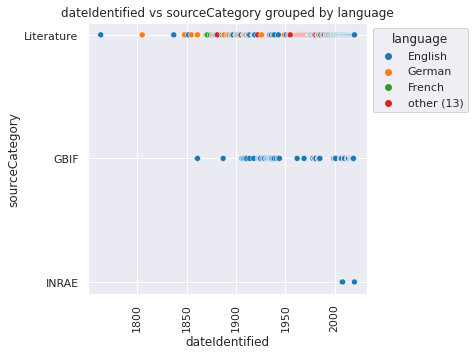

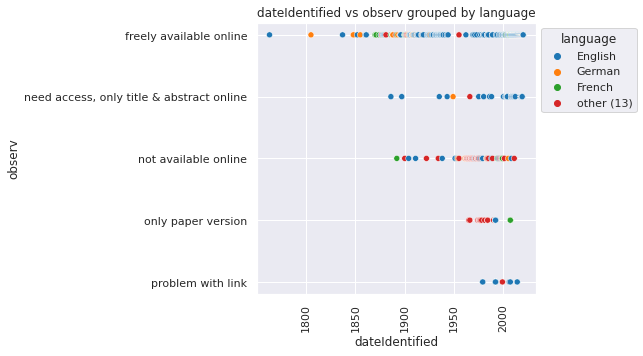

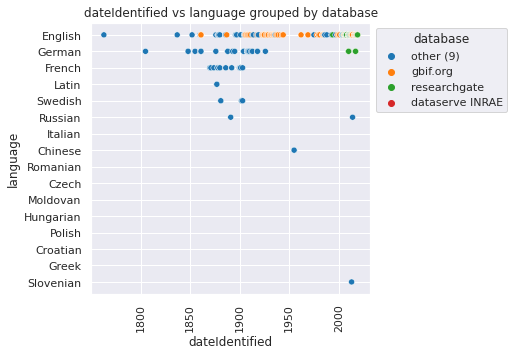

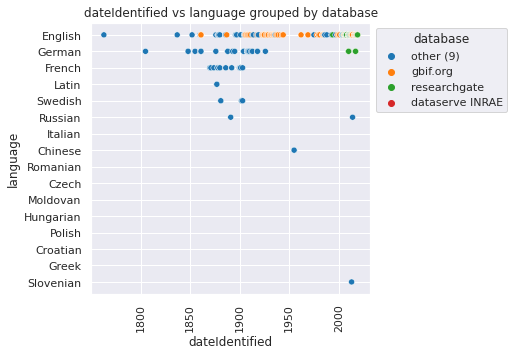

In [ ]:
for sg in subgroups:
    x='dateIdentified'
    hue=sg[0]
    y=sg[1]
    if hue==y or sum([(p in source_group_kws) for p in [p[:2] for p in list(permutations((hue,y,x)))]]):
        continue
    plot(x=x, y=y, hue=hue, data=df,
        type='scatter',
        legend_position='out',
        split={hue:4},
        save_path=os.path.join('pngs','fca_'+hue+'_'+y)
        )